##### Dataset Combined

In [97]:
import pandas as pd

def load_data():
    # Read CSV files into DataFrames
    mp_and_pdb = pd.read_csv("data/membrane_proteins.csv")
    mp_and_pdb.drop(columns="resolution", inplace=True)
    uniprot = pd.read_csv("data/membrane_protein_uniprot.csv")
    # uniprot.drop(columns="resolution", inplace=True)
    opm = pd.read_csv("data/membrane_protein_opm.csv")
    opm.drop(columns="resolution", inplace=True)

    # Normalize keys
    mp_and_pdb["pdb_code"] = mp_and_pdb["pdb_code"].str.strip().str.upper()
    opm["pdb_code"] = opm["pdb_code"].str.strip().str.upper()
    mp_and_pdb["uniprot_id"] = mp_and_pdb["uniprot_id"].str.strip().str.upper()
    uniprot["uniprot_id"] = uniprot["uniprot_id"].str.strip().str.upper()

    # Remove duplicates
    mp_and_pdb = mp_and_pdb.drop_duplicates(subset=["pdb_code", "uniprot_id"])
    opm = opm.drop_duplicates(subset=["pdb_code"])
    uniprot = uniprot.drop_duplicates(subset=["uniprot_id"])

    # Merge step-by-step
    merged_with_opm = pd.merge(mp_and_pdb, opm, on="pdb_code", how="inner", suffixes=("_mp", "_opm"))
    all_data = pd.merge(merged_with_opm, uniprot, on="uniprot_id", how="inner", suffixes=("_opm", "_uniprot"))

    return all_data, uniprot, opm, mp_and_pdb
all_data, uniprot, opm, mp_and_pdb = load_data()
# Inspect the final DataFrame
# all_data


## Machine Learning

##### Implementation for Imputation

In [91]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np


def optimize_knn_imputation(dataframe, n_neighbors_options=[1, 3, 5, 7, 10], cv=5):
    numeric_data = dataframe.select_dtypes(include=[np.number])
    if numeric_data.empty:
        raise ValueError("No numeric data available for imputation.")

    # Identify columns with all NaN values
    all_nan_columns = numeric_data.columns[numeric_data.isna().all()]
    # print(f"Columns with all NaN values: {list(all_nan_columns)}")

    # Drop columns with all NaN values before imputation
    numeric_data_cleaned = numeric_data.drop(columns=all_nan_columns)

    # Initialize cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    best_score = float('inf')
    best_k = None

    # Optimize KNNImputer
    for k in n_neighbors_options:
        imputer = KNNImputer(n_neighbors=k)
        try:
            # Initialize a list to store scores for this k
            fold_scores = []

            # Perform K-fold cross-validation
            for train_index, test_index in kf.split(numeric_data_cleaned):
                train_data, test_data = numeric_data_cleaned.iloc[train_index], numeric_data_cleaned.iloc[test_index]
                imputer.fit(train_data)
                imputed_data = imputer.transform(test_data)

                # Calculate mean squared error for this fold
                mse = np.mean((imputed_data - test_data) ** 2)
                fold_scores.append(mse)

            # Compute the mean MSE for this k
            mean_score = np.mean(fold_scores)
            # print(f"K={k}, Mean Squared Error: {mean_score}")

            if mean_score < best_score:
                best_score = mean_score
                best_k = k

        except Exception as e:
            print(f"Error during cross-validation for k={k}: {e}")
            continue

    # Use the best K for imputation
    best_k = best_k if best_k else n_neighbors_options[0]
    imputer = KNNImputer(n_neighbors=best_k)
    imputed_data = imputer.fit_transform(numeric_data_cleaned)

    # Create DataFrame from imputed data
    imputed_df = pd.DataFrame(imputed_data, index=numeric_data.index, columns=numeric_data_cleaned.columns)

    # Add back columns with all NaN values
    for col in all_nan_columns:
        imputed_df[col] = np.nan

    # Ensuring the column order matches the original DataFrame
    imputed_df = imputed_df[numeric_data.columns]

    return imputed_df, {"n_neighbors": best_k, "mean_score": best_score}

def impute_and_merge(categorical_data, numeric_data, categorical_n_neighbors=[1, 3, 5, 7], numeric_n_neighbors=[1, 3, 5, 7]):
    # Impute numerical data
    numeric_imputed, numeric_model = optimize_knn_imputation(numeric_data, numeric_n_neighbors)

    # Impute categorical data (treat one-hot encoded as numerical)
    categorical_imputed, categorical_model = optimize_knn_imputation(categorical_data, categorical_n_neighbors)

    # Merge imputed datasets
    merged_data = pd.concat([categorical_imputed, numeric_imputed], axis=1)

    return merged_data, {"categorical_model": categorical_model, "numeric_model": numeric_model}


def onehot_encoder(data, columns=None, drop=None, exempt_columns=None):
    if columns is None:
        # Automatically detect categorical columns if not provided
        columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

    # Exclude exempt columns from encoding
    exempt_columns = exempt_columns or []
    columns_to_encode = [col for col in columns if col not in exempt_columns]

    # Extract exempted columns
    exempted_data = data[exempt_columns] if exempt_columns else pd.DataFrame(index=data.index)

    # One-hot encode remaining columns
    if columns_to_encode:
        encoder = OneHotEncoder(drop=drop, sparse_output=False)
        encoded_data = encoder.fit_transform(data[columns_to_encode])
        encoded_columns = encoder.get_feature_names_out(columns_to_encode)
        encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=data.index)
    else:
        encoded_df = pd.DataFrame(index=data.index)

    # Combine exempted columns and encoded data
    final_df = pd.concat([encoded_df, exempted_data], axis=1)
    return final_df



##### Preprocessing Stage

In [92]:
from src.Jobs.transformData import report_and_clean_missing_values
from utils.package import drop_columns, drop_id_columns, impute_knn_best_hyperparameter, separate_numerical_categorical


# 1. separate data into numerical and categorical
# 2. Remove columns with emptiness based on percentage
# 3. One hot encode categorical data
# 4. Impute missing values
# Step 1: Clean and preprocess the data
clean_df = report_and_clean_missing_values(all_data, threshold=30)
# clean_df = clean_df[clean_df["rcsentinfo_experimental_method"] == "EM"]

# Step 2: Separate numerical and categorical data
numerical_cols, categorical_cols = separate_numerical_categorical(clean_df)

categorical_data = drop_id_columns(clean_df[categorical_cols])
categorical_data = drop_columns(
    categorical_data,
    [
        "is_master_protein", "pdb_code_opm", "name_mp", "description",
        "related_pdb_entries", "rcsentinfo_na_polymer_entity_types",
        "rcsb_primary_citation_country", "citation_country", "pdbid",
        "name_opm", "group", "subgroup", "molecular_function",
        "cellular_component", "biological_process", "species_description",
        "species_name", "family_superfamily_classtype_name",
        "family_superfamily_name", "family_name",
        "rcsentinfo_selected_polymer_entity_types", "expressed_in_species",
        "taxonomic_domain", "species", "rcsentinfo_experimental_method",
        "species_name_cache", "membrane_short_name", "membrane_name_cache",
        "species_name_cache", "famsupclasstype_type_name",
        "family_name_cache", "exptl_method", "rcsentinfo_polymer_composition",
        "exptl_crystal_grow_method", "exptl_crystal_grow_method1", "membrane_name",
        "info_created", "expcrygrow_pdbx_details", "info_sequence_update", "organism_scientific_name",
        "organism_common_name", "organism_lineage", "secondary_accession", "protein_recommended_name",
        "associated_genes", "sequence_sequence", "protein_alternative_name",
        "rcsentinfo_diffrn_resolution_high_provenance_source", "symspagroup_name_hm",
        "difradpdbx_scattering_type", "difradpdbx_scattering_type", "info_type",
        "info_modified", "membrane_topology_out"
    ]
)

numeric_data = drop_id_columns(clean_df[numerical_cols])

# Step 3: One-hot encode categorical data
# Specify exempt columns
exempt_cols = ["pdb_code_uniprot"]

# One-hot encode with exemptions
onehot_data = onehot_encoder(categorical_data, exempt_columns=exempt_cols)

# Step 4: Impute and merge
final_data, models_info = impute_and_merge(onehot_data, numeric_data)

# Display results
# print("Final Imputed DataFrame:\n", final_data.head())
# print("Imputation Models Info:", models_info)


# all_processed_data = pd.concat([onehot_data, fixed_missing_data], axis=1)
final_data.drop(["bibliography_year"], axis=1, inplace=True)
all_processed_data = final_data

Columns with all NaN values: []
K=1, Mean Squared Error: 0.0
K=3, Mean Squared Error: 0.0
K=5, Mean Squared Error: 0.0
K=7, Mean Squared Error: 0.0
Columns with all NaN values: []
K=1, Mean Squared Error: 0.0
K=3, Mean Squared Error: 0.0
K=5, Mean Squared Error: 0.0
K=7, Mean Squared Error: 0.0


##### Feature Importance

In [93]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def calculate_feature_importance(model, feature_names, plot=True, top_n=100):
    # Check if the model has feature_importances_
    if not hasattr(model, "feature_importances_"):
        raise ValueError("The model does not have a `feature_importances_` attribute.")

    # Extract feature importance
    importance = model.feature_importances_
    # Create a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    if plot:
        # Plot the top_n features
        importance_df.head(top_n).sort_values(by='Importance').plot(
            kind='barh', x='Feature', y='Importance', legend=False, figsize=(100, 150)
        )
        plt.title("Top Feature Importances", fontsize=60)
        plt.xlabel("Importance", fontsize=100)
        plt.ylabel("Feature", fontsize=100)
        plt.xticks(fontsize=100)
        plt.yticks(fontsize=100)
        plt.show()

    return importance_df

# Could test with these features as well , "subgroup", "family_name", "taxonomic_domain"
all_processed_data_with_labels = pd.concat([all_processed_data, clean_df[["group"]]], axis=1)

feature_names = all_processed_data.columns
# Train a model
model = RandomForestClassifier()
model.fit(all_processed_data, clean_df[["group"]])

# Calculate and visualize feature importance
feature_importance_df = calculate_feature_importance(model, feature_names)


/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



##### Using Selections from the chart above to make more informed decision for features

In [5]:
all_processed_data.drop([
    "rcsentinfo_assembly_count",
    "rcsentinfo_branched_entity_count", "rcsentinfo_cis_peptide_count",
    "rcsentinfo_deposited_atom_count","rcsentinfo_deposited_deuterated_water_count",
    "rcsentinfo_deposited_hydrogen_atom_count","rcsentinfo_deposited_model_count",
    "rcsentinfo_deposited_modeled_polymer_monomer_count","rcsentinfo_deposited_nonpolymer_entity_instance_count",
    "rcsentinfo_deposited_polymer_entity_instance_count","rcsentinfo_deposited_polymer_monomer_count",
    "rcsentinfo_deposited_solvent_atom_count","rcsentinfo_deposited_unmodeled_polymer_monomer_count",
    "rcsentinfo_disulfide_bond_count","rcsentinfo_entity_count","rcsentinfo_experimental_method_count",
    "rcsentinfo_inter_mol_covalent_bond_count","rcsentinfo_inter_mol_metalic_bond_count",
    "rcsentinfo_molecular_weight","rcsentinfo_nonpolymer_entity_count","rcsentinfo_nonpolymer_molecular_weight_maximum",
    "rcsentinfo_nonpolymer_molecular_weight_minimum","rcsentinfo_polymer_entity_count",
    "rcsentinfo_polymer_entity_count_dna","rcsentinfo_polymer_entity_count_rna",
    "rcsentinfo_polymer_entity_count_nucleic_acid","rcsentinfo_polymer_entity_count_protein",
    "rcsentinfo_polymer_entity_taxonomy_count","rcsentinfo_polymer_molecular_weight_maximum",
    "rcsentinfo_polymer_molecular_weight_minimum","rcsentinfo_polymer_monomer_count_maximum",
    "rcsentinfo_polymer_monomer_count_minimum",
    "rcsentinfo_solvent_entity_count",
    # "processed_resolution",
    # "thickness",
    "thicknesserror",
    # "subunit_segments","tilt",
    "tilterror",
    # "gibbs",
    "annotation_score",
    # "sequence_length","sequence_mass"
], axis=1, inplace=True)



###### Confirm our selections

In [6]:
all_processed_data

membrane_topology_in_cytoplasmic side  \
0                                       1.0   
1                                       1.0   
2                                       1.0   
3                                       1.0   
4                                       1.0   
...                                     ...   
2852                                    0.0   
2853                                    1.0   
2854                                    1.0   
2855                                    1.0   
2856                                    1.0   

      membrane_topology_in_cytoplasmic side   membrane_topology_in_inner side  \
0                                        0.0                              0.0   
1                                        0.0                              0.0   
2                                        0.0                              0.0   
3                                        0.0                              0.0   
4                                        0.0                              0.0   
...                                      ...                              ...   
2852                                     0.0                              0.0   
2853                                     0.0                              0.0   
2854                                     0.0                              0.0   
2855                                     0.0                              0.0   
2856                                     0.0                              0.0   

      membrane_topology_in_intravirion side  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
2852                                    0.0   
2853                                    0.0   
2854                                    0.0   
2855                                    0.0   
2856                                    0.0   

      membrane_topology_in_mitochondrial matrix  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
...                                         ...   
2852                                        0.0   
2853                                        0.0   
2854                                        0.0   
2855                                        0.0   
2856                                        0.0   

      membrane_topology_in_periplasm  membrane_topology_in_stroma  \
0                                0.0                          0.0   
1                                0.0                          0.0   
2                                0.0                          0.0   
3                                0.0                          0.0   
4                                0.0                          0.0   
...                              ...                          ...   
2852                             0.0                          1.0   
2853                             0.0                          0.0   
2854                             0.0                          0.0   
2855                             0.0                          0.0   
2856                             0.0                          0.0   

      processed_resolution  thickness  subunit_segments  tilt  gibbs  \
0                     3.50        8.9               0.0  90.0  -43.4   
1                     3.40        8.9               0.0  90.0  -43.4   
2                     3.10        8.9               0.0  90.0  -43.4   
3                     2.61        8.9               0.0  90.0  -43.4   
4                     3.20        8.9               0.0  90.0  -43.4   
...                    ...   

##### Dimensionality Reduction

In [7]:
# Example usage:
from utils.package import evaluate_dimensionality_reduction
import altair as alt

methods_params = {
    'PCA': {'n_components': 2},
    't-SNE': {'perplexity': 50},
    'UMAP': {'n_neighbors': 15}
}

reduced_data, plot_data = evaluate_dimensionality_reduction(all_processed_data, methods_params)


##### Using PCA

In [8]:
combined_plot_data = pd.concat(plot_data)

# append categorical data
other_label = clean_df[["group", "subgroup", "family_name", "taxonomic_domain"]]
categorical_data = categorical_data.reset_index(drop=True)
combined_plot_data = pd.concat(plot_data).reset_index(drop=True)
data_combined_PCA = pd.concat([categorical_data, combined_plot_data[combined_plot_data["Method"] == "PCA"], other_label], axis=1)

# Plot using Altair
alt.Chart(data_combined_PCA).mark_circle().encode(
    x='Component 1',
    y='Component 2',
    color='group',
    tooltip=['Method', 'Parameter']
).transform_filter(
    (alt.datum.Method == "PCA") & (alt.datum.group != None)
).properties(
    width=600,
    height=400
).interactive()

alt.Chart(...)

##### Using t-SNE

In [9]:
alt.data_transformers.disable_max_rows()
t_sne = combined_plot_data[combined_plot_data["Method"] == "t-SNE"].reset_index()
data_combined_t_SNE = pd.concat([categorical_data, t_sne, other_label], axis=1)

alt.Chart(data_combined_t_SNE).mark_circle().encode(
    x='Component 1',
    y='Component 2',
    color='group',
    tooltip=['Method', 'Parameter']
).transform_filter(
    (alt.datum.Method == "t-SNE") & (alt.datum.group != None)
).properties(
    width=600,
    height=400
).interactive()

alt.Chart(...)

#### Using UMAP

In [10]:
alt.data_transformers.disable_max_rows()
umap_data = combined_plot_data[combined_plot_data["Method"] == "UMAP"].reset_index()
data_combined_UMAP = pd.concat([categorical_data, umap_data, other_label], axis=1)

alt.Chart(data_combined_UMAP).mark_circle().encode(
    x='Component 1',
    y='Component 2',
    color='group',
    tooltip=['Method', 'Parameter']
).transform_filter(
    (alt.datum.Method == "UMAP")
).properties(
    width=600,
    height=400
).interactive()

alt.Chart(...)

## Semi Supervised Learning

In [111]:
import os, sys
sys.path.append(os.getcwd())
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    cross_validate, 
    StratifiedKFold,
    KFold
)
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import (
    make_scorer, 
    f1_score, 
    precision_score, 
    recall_score, 
    accuracy_score
)
from app import app
import altair as alt
from database.db import db
from src.Dashboard.services import get_tables_as_dataframe, get_table_as_dataframe
from src.Jobs.Utils import (
    ClassifierComparison, onehot_encoder, ClassifierComparisonSemiSupervised,
    select_features_using_decision_tree, separate_numerical_categorical,
    evaluate_dimensionality_reduction
)
from src.Jobs.transformData import report_and_clean_missing_values

class MLJob:
    def __init__(self):
        self.num_runs = 1  # Define the number of runs for averaging metrics
        self.random_state = 42  # For reproducibility
        np.random.seed(self.random_state)
        
        # Load data
        self.load_data()
        self.models = {}  # Initialize self.models as an empty dictionary
        # Data containers
        self.data = pd.DataFrame()
        self.numerical_data = pd.DataFrame()
        self.categorical_data = pd.DataFrame()
        self.complete_numerical_data = pd.DataFrame()
        self.data_combined_PCA = pd.DataFrame()
        self.data_combined_tsne = pd.DataFrame()
        self.data_combined_UMAP = pd.DataFrame()
        self.semi_supervised_metrics = pd.DataFrame()
        self.supervised_metrics = pd.DataFrame()
        self.label_encoder = LabelEncoder()
        self.over_sampling_data_selected_feature_data = pd.DataFrame()
        
    def load_data(self):
        self.result_df, self.result_df_uniprot, self.result_df_opm, self.result_df_db = load_data()
        # print(result_df, result_df_uniprot, result_df_opm, result_df_db)
        self.all_data = pd.merge(self.result_df_db, self.result_df_opm, on="pdb_code", how="inner", suffixes=("_mp", "_opm"))
        # Reset index before filtering
        self.all_data = self.all_data.reset_index(drop=True)
        # Reserve some data for test specifically for discrepancies
        exclude_pdb_codes = [
            "1PFO", "1B12", "1GOS", "1MT5", "1KN9", "1OJA", "1O5W", "1UUM", "1T7D", "2BXR",
            "1YGM", "2GMH", "2OLV", "2OQO", "2QCU", "2PRM", "2Z5X", "2VQG", "3HYW", "3I65",
            "3VMA", "3NSJ", "3ML3", "3PRW", "3P1L", "3Q7M", "2YH3", "3LIM", "3VMT", "3Q54",
            "2YMK", "2LOU", "4LXJ", "4HSC", "4CDB", "4P6J", "4TSY", "5B49", "5IMW", "5IMY",
            "5JYN", "5LY6", "6BFG", "6MLU", "6DLW", "6H03", "6NYF", "6MTI", "7OFM", "7LQ6",
            "7RSL", "8A1D", "7QAM"
        ]
        
        self.all_data = self.all_data[~self.all_data['pdb_code'].isin(exclude_pdb_codes)]
        
    
    def fix_missing_data(self):
        self.data = report_and_clean_missing_values(self.all_data, threshold=30)
        columns_to_drop = [col for col in self.data.columns if '_citation_' in col or '_count_' in col or col.startswith('count_') or col.endswith('_count') or col.startswith('revision_') or col.endswith('_revision') or col.startswith('id_') or col.endswith('_id') or col == "id"]
        self.data.drop(columns_to_drop + [
            'pdbid', 'name_mp', 'name_opm', 'tilterror', 'description', 'family_name', 
            'species_name', 'exptl_method', 'thicknesserror', 'citation_country', 
            'family_name_cache', "bibliography_year", 'is_master_protein', 
            'species_name_cache', 'membrane_name_cache', 'species_description', 
            'membrane_short_name', "processed_resolution", 'family_superfamily_name', 
            'famsupclasstype_type_name', 'exptl_crystal_grow_method', 
            'exptl_crystal_grow_method1', 'family_superfamily_classtype_name', 
            'rcsentinfo_nonpolymer_molecular_weight_maximum', 
            'rcsentinfo_nonpolymer_molecular_weight_minimum', 
            "rcsentinfo_polymer_molecular_weight_minimum", "rcsentinfo_molecular_weight", 
            "rcsentinfo_polymer_molecular_weight_maximum", 'gibbs'
        ], axis=1, inplace=True)
        return self

    def variable_separation(self):
        data = self.data.dropna()
        numerical_cols, categorical_cols = separate_numerical_categorical(data)
        self.numerical_data = data[numerical_cols]
        self.categorical_data = data[categorical_cols]
        return self
    
    def feature_selection(self):
        self.categorical_data.reset_index(drop=True, inplace=True)
        encode_data = self.categorical_data[["membrane_topology_in", "membrane_topology_out"]]
        # encoded_data = onehot_encoder(encode_data)
        # encoded_data.reset_index(drop=True, inplace=True)
        encoded_data = pd.DataFrame([])
        encoded_data['membrane_topology_in'] = self.label_encoder.fit_transform(self.categorical_data['membrane_topology_in'])
        encoded_data['membrane_topology_out'] = self.label_encoder.fit_transform(self.categorical_data['membrane_topology_out'])
        
        
        self.numerical_data.reset_index(drop=True, inplace=True)
        self.complete_numerical_data = pd.concat([self.numerical_data, encoded_data], axis=1).reset_index(drop=True)
        
        label_encoder = LabelEncoder()
        y = self.categorical_data["group"]
        y_encoded = label_encoder.fit_transform(y)
        y_data_frame = pd.DataFrame(y_encoded, columns=['group']).reset_index(drop=True)
        
        combined_data = pd.concat([self.complete_numerical_data, y_data_frame], axis=1).dropna()
        self.complete_numerical_data, top_features = select_features_using_decision_tree(combined_data, target_column='group', num_features=30)
        print(top_features)
        
        self.over_sampling_data_selected_feature_data = pd.concat([self.complete_numerical_data, y], axis=1)
        
        raw_data = pd.concat([
            self.numerical_data, 
            self.categorical_data[[
                    "pdb_code", "membrane_topology_in", 
                    "membrane_topology_out",
                    "group"
                ]
            ]], axis=1)
        raw_data.reset_index(drop=True, inplace=True)
        raw_data.to_csv("./models/semi-supervised/without_reduction_data.csv", index=False)
        return self
        
    def dimensionality_reduction(self):
        methods_params = {
            'PCA': {'n_components': 2},
            't-SNE': {'n_components': 2, 'perplexity': 30},
            'UMAP': {'n_components': 2, 'n_neighbors': 15}
        }
        self.complete_numerical_data = self.over_sampling_data_selected_feature_data.iloc[:, :-1]
        categorical_data = self.over_sampling_data_selected_feature_data["group"]
        
        reduced_data, plot_data = evaluate_dimensionality_reduction(self.complete_numerical_data, methods_params)
        combined_plot_data = pd.concat(plot_data)
        
        self.data_combined_PCA = pd.concat([combined_plot_data[combined_plot_data["Method"] == "PCA"].reset_index(drop=True), categorical_data], axis=1)
        self.data_combined_PCA.to_csv("./models/semi-supervised/PCA_data.csv", index=False)
        
        self.data_combined_tsne = pd.concat([combined_plot_data[combined_plot_data["Method"] == "t-SNE"].reset_index(drop=True), categorical_data], axis=1)
        self.data_combined_tsne.to_csv("./models/semi-supervised/TSNE_data.csv", index=False)
        
        self.data_combined_UMAP = pd.concat([combined_plot_data[combined_plot_data["Method"] == "UMAP"].reset_index(drop=True), categorical_data], axis=1)
        self.data_combined_UMAP.to_csv("./models/semi-supervised/UMAP_data.csv", index=False)
        
        return self

    def plot_charts(self):
        chart_list = {
            "pca": self.data_combined_PCA,
            "tsne": self.data_combined_tsne,
            "umap": self.data_combined_UMAP
        }
        
        for key, obj in chart_list.items():
            chart = alt.Chart(obj).mark_circle().encode(
                x='Component 1',
                y='Component 2',
                color='group',
                tooltip=["group"]
            ).properties(width=800, height=500)
            chart.save('models/' + key + '.png', scale_factor=2.0)
        return self

    def run_classificationXXX(self, X, y, model_class, filename_prefix, X_unlabeled=None):
        """Run classification and save results."""
        metrics_list = []

        for run in range(self.num_runs):
            if X_unlabeled is not None:  # Semi-Supervised Case
                model = model_class(X, y, X_unlabeled, test_size=0.2, random_state=self.random_state + run)
            else:  # Supervised Case
                model = model_class(X, y, test_size=0.2, random_state=self.random_state + run)

            # Train and evaluate the models
            model.train_and_evaluate()

            # Collect metrics for aggregation
            metrics_list.append(model.results_df)

            # Save model and plot performance
            model.save_models(save_filename=f"{filename_prefix}_{run}")
            model.plot_performance_comparison(save_filename=f"{filename_prefix}_{run}")

        # Concatenate all metric results
        concatenated_metrics = pd.concat(metrics_list)

        # Select only numeric columns for aggregation
        numeric_columns = concatenated_metrics.select_dtypes(include=['number'])

        # Aggregate only numeric columns
        aggregated_metrics = numeric_columns.groupby(level=0).agg(['mean', 'std'])

        # Combine non-numeric data with aggregated numeric data (if needed)
        non_numeric_columns = concatenated_metrics.select_dtypes(exclude=['number']).drop_duplicates()
        if not non_numeric_columns.empty:
            aggregated_metrics = pd.concat([aggregated_metrics, non_numeric_columns], axis=1)

        # Save aggregated metrics
        aggregated_metrics.to_csv(f"./models/{filename_prefix}_metrics_mean.csv")
        print(f"Metrics saved to ./models/{filename_prefix}_metrics_mean.csv")      
    
    
    def plot_metrics_altair(self, metrics_data):
        # Convert metrics_data to a DataFrame
        metrics_df = pd.DataFrame(metrics_data)
        
        # Melt the DataFrame to long format for Altair
        plot_data = metrics_df.melt(id_vars='Classifier', value_vars=['Mean Accuracy', 'Mean F1-Score', 'Mean Precision', 'Mean Recall'],
                                    var_name='Metric', value_name='Score')
        
        # Create a grouped bar chart with Altair
        chart = alt.Chart(plot_data).mark_bar().encode(
            x=alt.X('Classifier:N', title='Classifier'),
            y=alt.Y('Score:Q', title='Score'),
            color=alt.Color('Metric:N', title='Metric'),
            column=alt.Column('Metric:N', title='Metric')
        ).properties(
            title='Mean Performance Metrics for Each Classifier',
            width=200,
            height=300
        ).configure_axis(
            labelAngle=-45
        ).configure_view(
            stroke='transparent'
        )
        
        # Save the plot as a file
        chart.save('./models/metrics_comparison_altair.png')
        
    def run_classification(self, X, y, model_class, filename_prefix, X_unlabeled=None):
        """Run classification and save results."""
        metrics_list = []
        best_model = None
        best_score = -float('inf')  # Initialize with a very low value
        # Create an empty list to collect metrics for saving to CSV
        metrics_data = []
        
        for run in range(self.num_runs):
            if X_unlabeled is not None:  # Semi-Supervised Case
                model = model_class(X, y, X_unlabeled, test_size=0.2, random_state=self.random_state + run)
            else:  # Supervised Case
                model = model_class(X, y, test_size=0.2, random_state=self.random_state + run)

            # Train and evaluate the models
            model.train_and_evaluate()
            # Define stratified cross-validation
            # skf = StratifiedKFold(n_splits=5)
            kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state + run)
            # Perform cross-validation for each classifier using multiple metrics
            for clf_name, clf in model.models.items():
                scoring = {
                    'accuracy': make_scorer(accuracy_score),
                    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
                    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
                    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0)
                }
                
                cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring, return_train_score=False)
                
                # Calculate mean scores for each metric
                mean_accuracy = cv_results['test_accuracy'].mean()
                mean_f1 = cv_results['test_f1_weighted'].mean()
                mean_precision = cv_results['test_precision_weighted'].mean()
                mean_recall = cv_results['test_recall_weighted'].mean()

                # Collect metrics data for saving to CSV
                metrics_data.append({
                    'Run': run,
                    'Classifier': clf_name,
                    'Accuracy Scores': cv_results['test_accuracy'],
                    'Mean Accuracy': mean_accuracy,
                    'F1-Score': cv_results['test_f1_weighted'],
                    'Mean F1-Score': mean_f1,
                    'Precision': cv_results['test_precision_weighted'],
                    'Mean Precision': mean_precision,
                    'Recall': cv_results['test_recall_weighted'],
                    'Mean Recall': mean_recall
                })

                # Evaluate and update the best model based on chosen metric
                if mean_f1 > best_score:
                    best_score = mean_f1
                    best_model = clf
                    best_clf_name = clf_name

                # Collect metrics for aggregation
                metrics_list.append(model.results_df)

            # Save models and plot performance only after all runs
            model.save_models(save_filename=f"{filename_prefix}_{run}")
            model.plot_performance_comparison(save_filename=f"{filename_prefix}_{run}")

        # Save the best model once after all runs
        if best_model is not None:
            # Use the last run number or a specific number if preferred
            self.save_best_model(best_model, best_clf_name, filename_prefix, self.num_runs - 1)

        # Convert metrics data to DataFrame
        metrics_df = pd.DataFrame(metrics_data)

        # Save metrics to CSV
        metrics_df.to_csv(f"./models/{filename_prefix}_cross_validation_metrics.csv", index=False)
        print(f"Cross-validation metrics saved to ./models/{filename_prefix}_cross_validation_metrics.csv")

        # Concatenate all metric results
        concatenated_metrics = pd.concat(metrics_list)

        # Select only numeric columns for aggregation
        numeric_columns = concatenated_metrics.select_dtypes(include=['number'])

        # Aggregate only numeric columns
        aggregated_metrics = numeric_columns.groupby(level=0).agg(['mean', 'std'])

        # Combine non-numeric data with aggregated numeric data (if needed)
        non_numeric_columns = concatenated_metrics.select_dtypes(exclude=['number']).drop_duplicates()
        if not non_numeric_columns.empty:
            aggregated_metrics = pd.concat([aggregated_metrics, non_numeric_columns], axis=1)

        # Save aggregated metrics
        aggregated_metrics.to_csv(f"./models/{filename_prefix}_metrics_mean.csv")
        print(f"Metrics saved to ./models/{filename_prefix}_metrics_mean.csv")
        
        self.plot_metrics_altair(metrics_data)
    
    def save_best_model(self, model, clf_name, filename_prefix, run):
        """Save the best model based on selected metric."""
        joblib.dump(model, f'./models/{filename_prefix}_best_{clf_name}_{run}.joblib')
        print(f"Best model saved to ./models/{filename_prefix}_best_{clf_name}_{run}.joblib")

    def semi_supervised_learning(self):
        """Run semi-supervised learning on different dimensionality-reduced datasets."""
        data_list = {
            "pca": self.data_combined_PCA,
            "tsne": self.data_combined_tsne,
            "umap": self.data_combined_UMAP
        }
        
        for key, data in data_list.items():
            # data["group"] = data["group"].replace({
            #     'TRANSMEMBRANE PROTEINS:ALPHA-HELICAL': 0,
            #     'TRANSMEMBRANE PROTEINS:BETA-BARREL': 1,
            #     'MONOTOPIC MEMBRANE PROTEINS': 2
            # })
            
            X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
                data[["Component 1", "Component 2"]],
                data["group"], test_size=0.3,
                stratify=data["group"].to_list(),
                random_state=self.random_state
            )
            
            # Semi-supervised learning requires both labeled and unlabeled data
            self.run_classification(X_labeled, y_labeled, ClassifierComparisonSemiSupervised, f"semi_supervised_{key}", X_unlabeled)

        # Without Dimensionality Reduction
        categorical_data = self.over_sampling_data_selected_feature_data["group"]
        # .replace({
        #     'TRANSMEMBRANE PROTEINS:ALPHA-HELICAL': 0,
        #     'TRANSMEMBRANE PROTEINS:BETA-BARREL': 1,
        #     'MONOTOPIC MEMBRANE PROTEINS': 2
        # })
        
        X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
            self.complete_numerical_data,
            categorical_data, test_size=0.66,
            stratify=categorical_data.to_list(),
            random_state=self.random_state
        )
        
        self.run_classification(X_labeled, y_labeled, ClassifierComparisonSemiSupervised, "semi_supervised_no_dr", X_unlabeled)
        
        return self

    def supervised_learning(self):
        """Run supervised learning on different dimensionality-reduced datasets."""
        data_list = {
            "pca": self.data_combined_PCA,
            "tsne": self.data_combined_tsne,
            "umap": self.data_combined_UMAP
        }
        
        for key, data in data_list.items():
            X = data[["Component 1", "Component 2"]]
            y = data["group"]
            
            self.run_classification(X, y, ClassifierComparison, f"supervised_{key}")
        
        # Without Dimensionality Reduction
        X = self.complete_numerical_data
        y = self.over_sampling_data_selected_feature_data["group"]
        self.run_classification(X, y, ClassifierComparison, "supervised_no_dr")
        
        return self


ml_job = MLJob()
    
# Run the steps sequentially
ml_job.fix_missing_data()\
        .variable_separation()\
        .feature_selection()\
        .dimensionality_reduction()\
        .plot_charts()\
        .semi_supervised_learning()\
        .supervised_learning()

print("Machine Learning Job completed successfully.")


SHAP summary plot saved as ./models/shap_bar_plot.png
['membrane_topology_in', 'thickness', 'tilt', 'membrane_topology_out', 'subunit_segments']
Labeled set distribution:
 group
TRANSMEMBRANE PROTEINS:ALPHA-HELICAL    1409
TRANSMEMBRANE PROTEINS:BETA-BARREL       171
MONOTOPIC MEMBRANE PROTEINS               29
Name: count, dtype: int64
Unlabeled set distribution:
 group
TRANSMEMBRANE PROTEINS:ALPHA-HELICAL    353
TRANSMEMBRANE PROTEINS:BETA-BARREL       43
MONOTOPIC MEMBRANE PROTEINS               7
Name: count, dtype: int64
X_combined shape: (2472, 2)
y_combined shape: (2472,)
Number of labeled samples in y_combined: 1609
Number of unlabeled samples in y_combined: 863


/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled s

Best model saved to ./models/semi_supervised_pca_best_Random Forest_0.joblib
Cross-validation metrics saved to ./models/semi_supervised_pca_cross_validation_metrics.csv
Metrics saved to ./models/semi_supervised_pca_metrics_mean.csv
Labeled set distribution:
 group
TRANSMEMBRANE PROTEINS:ALPHA-HELICAL    1409
TRANSMEMBRANE PROTEINS:BETA-BARREL       171
MONOTOPIC MEMBRANE PROTEINS               29
Name: count, dtype: int64
Unlabeled set distribution:
 group
TRANSMEMBRANE PROTEINS:ALPHA-HELICAL    353
TRANSMEMBRANE PROTEINS:BETA-BARREL       43
MONOTOPIC MEMBRANE PROTEINS               7
Name: count, dtype: int64
X_combined shape: (2472, 2)
y_combined shape: (2472,)
Number of labeled samples in y_combined: 1609
Number of unlabeled samples in y_combined: 863


/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled s

Best model saved to ./models/semi_supervised_tsne_best_KNeighbors Classifier_0.joblib
Cross-validation metrics saved to ./models/semi_supervised_tsne_cross_validation_metrics.csv
Metrics saved to ./models/semi_supervised_tsne_metrics_mean.csv
Labeled set distribution:
 group
TRANSMEMBRANE PROTEINS:ALPHA-HELICAL    1409
TRANSMEMBRANE PROTEINS:BETA-BARREL       171
MONOTOPIC MEMBRANE PROTEINS               29
Name: count, dtype: int64
Unlabeled set distribution:
 group
TRANSMEMBRANE PROTEINS:ALPHA-HELICAL    353
TRANSMEMBRANE PROTEINS:BETA-BARREL       43
MONOTOPIC MEMBRANE PROTEINS               7
Name: count, dtype: int64
X_combined shape: (2472, 2)
y_combined shape: (2472,)
Number of labeled samples in y_combined: 1609
Number of unlabeled samples in y_combined: 863


/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled s

Best model saved to ./models/semi_supervised_umap_best_KNeighbors Classifier_0.joblib
Cross-validation metrics saved to ./models/semi_supervised_umap_cross_validation_metrics.csv
Metrics saved to ./models/semi_supervised_umap_metrics_mean.csv
Labeled set distribution:
 group
TRANSMEMBRANE PROTEINS:ALPHA-HELICAL    684
TRANSMEMBRANE PROTEINS:BETA-BARREL       83
MONOTOPIC MEMBRANE PROTEINS              14
Name: count, dtype: int64
Unlabeled set distribution:
 group
TRANSMEMBRANE PROTEINS:ALPHA-HELICAL    172
TRANSMEMBRANE PROTEINS:BETA-BARREL       21
MONOTOPIC MEMBRANE PROTEINS               3
Name: count, dtype: int64
X_combined shape: (2679, 5)
y_combined shape: (2679,)
Number of labeled samples in y_combined: 781
Number of unlabeled samples in y_combined: 1898


/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled samples

/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:214: UserWarning:

y contains no unlabeled s

Best model saved to ./models/semi_supervised_no_dr_best_Random Forest_0.joblib
Cross-validation metrics saved to ./models/semi_supervised_no_dr_cross_validation_metrics.csv
Metrics saved to ./models/semi_supervised_no_dr_metrics_mean.csv
Best model saved to ./models/supervised_pca_best_Random Forest_0.joblib
Cross-validation metrics saved to ./models/supervised_pca_cross_validation_metrics.csv
Metrics saved to ./models/supervised_pca_metrics_mean.csv
Best model saved to ./models/supervised_tsne_best_KNeighbors Classifier_0.joblib
Cross-validation metrics saved to ./models/supervised_tsne_cross_validation_metrics.csv
Metrics saved to ./models/supervised_tsne_metrics_mean.csv
Best model saved to ./models/supervised_umap_best_KNeighbors Classifier_0.joblib
Cross-validation metrics saved to ./models/supervised_umap_cross_validation_metrics.csv
Metrics saved to ./models/supervised_umap_metrics_mean.csv
Best model saved to ./models/supervised_no_dr_best_Decision Tree_0.joblib
Cross-validatio

## Interactive Visualization

##### Cummulative Growth of Membrane Protein

In [11]:
import pandas as pd
import numpy as np
import altair as alt
import random
from scipy.optimize import curve_fit

import matplotlib.colors as mcolors

def generate_color_palette(start_color, end_color, num_colors):
    # Convert hex colors to RGB
    start_rgb = mcolors.hex2color(start_color)
    end_rgb = mcolors.hex2color(end_color)

    # Create a list of RGB colors in the gradient
    colors = []
    for i in range(num_colors):
        r = start_rgb[0] + (end_rgb[0] - start_rgb[0]) * (i / (num_colors - 1))
        g = start_rgb[1] + (end_rgb[1] - start_rgb[1]) * (i / (num_colors - 1))
        b = start_rgb[2] + (end_rgb[2] - start_rgb[2]) * (i / (num_colors - 1))
        colors.append((r, g, b))

    # Convert RGB colors back to hex
    hex_colors = [mcolors.rgb2hex(color) for color in colors]

    return hex_colors


title="page chart"

import_data = pd.read_csv("data/membrane_proteins.csv")
protein_db = import_data[import_data["is_master_protein"] == "MasterProtein"]

    # If not in cache, proceed with data retrieval and processing
    # protein_db = get_table_as_dataframe("membrane_proteins")


d = pd.crosstab(protein_db.bibliography_year, columns=protein_db.group).cumsum()

d = d.stack().reset_index()
d = d.rename(columns={0:'CumulativeCount'})
d = d.convert_dtypes()

#### Line fit start here
# Aggregate cumulative counts by year and group
aggregated_df = d.groupby(['bibliography_year', 'group'])['CumulativeCount'].sum().reset_index()

# Fit exponential model to the entire combined dataset
combined_df = aggregated_df.groupby('bibliography_year')['CumulativeCount'].sum().reset_index()


# Define exponential function for fitting
def exp_growth(x, a, b):
    return a * np.exp(b * (x - 2005))

# Extract year and cumulative count from DataFrame
years = combined_df['bibliography_year'].values
cumulative_count = combined_df['CumulativeCount'].values

# Use data from 1985 to 2004 to fit the exponential growth
# years_fit = years[:15]  # 1985 to 2004
# cumulative_count_fit = cumulative_count[:15]

# Find the indices for years between 1985 and 2005 (inclusive)
start_year = 1985
end_year = 2005
start_index = np.where(years == start_year)[0][0]
end_index = np.where(years == end_year)[0][0] + 1  # Including 2005

# Split the data for fitting
years_fit = years[start_index:end_index]  # From 1985 to 2005
cumulative_count_fit = cumulative_count[start_index:end_index]


# Fit the exponential growth curve
popt, _ = curve_fit(exp_growth, years_fit, cumulative_count_fit, p0=(100, 0.1))

# Generate points for the fitted curve
x_exp = np.arange(min(years), max(years) + 1)
y_exp = exp_growth(x_exp, *popt)

# Convert data to DataFrame
df_fit = pd.DataFrame({
    'Year': x_exp,
    'Fitted Growth': y_exp
})

# Determine y-axis limit from the actual data
y_max = cumulative_count.max()  # Set this to a bit above the max value for better visibility
df_fit = df_fit[df_fit['Fitted Growth'] <= y_max]

##### Line fit ends here+


# Define a custom color palette
start_color = '#005EB8'  # Red
end_color = '#B87200'    # Green

color_list = ['#D9DE84', '#005EB8', '#93C4F6', '#636B05']

# Generate a color palette with 10 colors
num_colors = len(list(protein_db['group'].unique()))
palette = generate_color_palette(start_color, end_color, num_colors)
random.shuffle(palette)

custom_palette = alt.Scale(domain=list(protein_db['group'].unique()),
                        range=color_list[:num_colors])
bars = alt.Chart(d).mark_bar().encode(
    x=alt.X('bibliography_year:O', title="Year"),
    y=alt.Y('CumulativeCount:Q', title = 'Entries'),
    color=alt.Color('group', scale=custom_palette, legend=alt.Legend(title="Groups", labelLimit=0, direction = 'vertical')),
    tooltip=[alt.Tooltip('CumulativeCount:Q'),
            alt.Tooltip('group'),
            alt.Tooltip('bibliography_year:O')]
)

# Add exponential fit line
line = alt.Chart(df_fit).mark_line(color='red', strokeDash=[5, 5]).encode(
    x=alt.X('Year:O', title='Year'),
    y=alt.Y('Fitted Growth:Q', title='Number of Structures', scale=alt.Scale(domain=[0, y_max])),
    tooltip=['Year', 'Fitted Growth']
)

# Combine charts
chart = bars + line

# Customize chart appearance
chart = chart.configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
).configure_view(
    stroke='transparent'
).configure_legend(
    orient='bottom',
        # padding=20, 
        offset=2,
        titleOrient='top',
        labelLimit=0,
    labelFontSize=12,
    titleFontSize=14
)
chart

alt.LayerChart(...)

##### Multiple Chart for MetaMP

In [12]:
import altair as alt
import pandas as pd
import os, sys
import numpy as np
from src.services.Helpers.helper import (
    generate_color_palette
)
from scipy.optimize import curve_fit

def create_combined_chart(protein_db, title="Cumulative sum of resolved Membrane Protein (MP) Structures over time", chart_width=800):
    # Ensure 'group' column exists and update it
    if 'group' not in protein_db.columns:
        raise KeyError("The 'group' column is missing from the DataFrame.")
    
    protein_db['group'] = protein_db['group'].replace({
        'MONOTOPIC MEMBRANE PROTEINS': "Group 1",
        'TRANSMEMBRANE PROTEINS:BETA-BARREL': "Group 2",
        'TRANSMEMBRANE PROTEINS:ALPHA-HELICAL': "Group 3",
    })
    
    # Define group labels and their meanings
    group_labels = {
        "Group 1": 'Group 1 (MONOTOPIC MEMBRANE PROTEINS)',
        "Group 2": 'Group 2 (TRANSMEMBRANE PROTEINS:BETA-BARREL)',
        "Group 3": 'Group 3 (TRANSMEMBRANE PROTEINS:ALPHA-HELICAL)'
    }
    
    # Add a 'label' column for detailed legend information
    protein_db['label'] = protein_db['group'].map(group_labels)
    
    
    # Define a custom color palette
    color_list = ['#D9DE84', '#93C4F6', '#005EB8']
    unique_group_list = list(protein_db['label'].unique())
    num_colors = len(unique_group_list)
    ordered_list = [
        'Group 1 (MONOTOPIC MEMBRANE PROTEINS)',
        'Group 2 (TRANSMEMBRANE PROTEINS:BETA-BARREL)',
        'Group 3 (TRANSMEMBRANE PROTEINS:ALPHA-HELICAL)'
    ]
    unique_group_list.sort(key=lambda x: ordered_list.index(x))
    custom_palette = alt.Scale(domain=unique_group_list, range=color_list[:num_colors])
    
    
    
    # Check if 'label' column was successfully created
    if 'label' not in protein_db.columns:
        raise KeyError("The 'label' column was not created successfully.")
    
    # Group by 'label' and count occurrences
    grouped_data = protein_db.groupby(["label", "group"]).size().reset_index(name='CumulativeCount')
    
    # Group by 'taxonomic domain' and count occurrences
    grouped_data_taxonomic_domain = protein_db[["taxonomic_domain", "label", "group"]].groupby(["taxonomic_domain", "label", "group"]).size().reset_index(name="CumulativeCount")
    
    # Sort by count
    grouped_data = grouped_data.sort_values(by='CumulativeCount', ascending=True)

    # Create a brush selection
    brush = alt.selection_interval(encodings=['x', 'y'])
    unique_group_list = list(protein_db['label'].unique())
    
    chart_width_2 = (chart_width - 100) / 2
    
    grouped_bar_chart = alt.Chart(grouped_data).mark_bar().encode(
        x=alt.X(
            'group:N', title='Group', sort=None, axis=alt.Axis(
                labelAngle=0,
                labelLimit=0
            )
        ),
        y=alt.Y('CumulativeCount:Q', title='Cumulative MP Structures'),
        color=alt.Color('label:N', scale=custom_palette, legend=alt.Legend(
            title="Group", 
            orient="bottom", 
            labelLimit=0, 
            direction="vertical"
            )
        ),
        tooltip=["label", "CumulativeCount"]
    ).add_params(
        brush
    ).properties(
        title=['Cumulative sum of resolved Membrane Protein (MP)', ' Structures categorized by group'],
        width=chart_width_2
    )
    
    grouped_bar_chart_taxonomic = alt.Chart(grouped_data_taxonomic_domain).mark_bar().encode(
        x=alt.X(
            'taxonomic_domain:N', title='Taxonomic Domain', sort=None, axis=alt.Axis(
                labelAngle=0,
                labelLimit=0
            ), 
        ),
        y=alt.Y('CumulativeCount:Q', title='Cumulative MP Structures'),
        color=alt.Color('label:N', scale=custom_palette, legend=None),
        tooltip=["label", "taxonomic_domain", "CumulativeCount"]
    ).transform_filter(
        brush
    ).properties(
        title=['Cumulative sum of resolved Membrane Protein (MP)', ' Structures categorized by taxonomic domain'],
        width=chart_width_2
    ).interactive()
    
    # Prepare the data for the cumulative chart with exponential fit
    d = pd.crosstab([protein_db["bibliography_year"]], columns=[protein_db["group"], protein_db["label"]]).cumsum()

    # Reset the index to convert 'bibliography_year' back to a column
    d = d.reset_index()

    # Melt the crosstab to get 'group' and 'label' as individual columns
    d = d.melt(
        id_vars=["bibliography_year"], 
        var_name=["group", "label"], 
        value_name="CumulativeCount"
    )
    # Aggregate cumulative counts by year and group
    aggregated_df = d.groupby(['bibliography_year', 'group'])['CumulativeCount'].sum().reset_index()
    combined_df = aggregated_df.groupby('bibliography_year')['CumulativeCount'].sum().reset_index()
    
    # Fit exponential model
    years = combined_df['bibliography_year'].values
    cumulative_count = combined_df['CumulativeCount'].values
    start_year, end_year = 1985, 2005
    start_index = np.where(years == start_year)[0][0]
    end_index = np.where(years == end_year)[0][0] + 1
    years_fit = years[start_index:end_index]
    cumulative_count_fit = cumulative_count[start_index:end_index]
    popt, _ = curve_fit(exp_growth, years_fit, cumulative_count_fit, p0=(100, 0.1))
    x_exp = np.arange(min(years), max(years) + 1)
    y_exp = exp_growth(x_exp, *popt)
    df_fit = pd.DataFrame({'Year': x_exp, 'Fitted Growth': y_exp})
    y_max = cumulative_count.max()
    df_fit = df_fit[df_fit['Fitted Growth'] <= y_max]
    
    entries_over_time = alt.Chart(d).mark_bar().encode(
        x=alt.X('bibliography_year:O', title="Year"),
        y=alt.Y('CumulativeCount:Q', title='Cumulative MP Structures', scale=alt.Scale(domain=[0, y_max])),
        color=alt.Color('label:N', scale=custom_palette, legend=None),
        tooltip=[alt.Tooltip('CumulativeCount:Q'), alt.Tooltip('label'), alt.Tooltip('bibliography_year:O')]
    ).transform_filter(
        brush
    ).properties(
        width=chart_width,
        title="Cumulative sum of resolved Membrane Protein (MP) Structures over time"
    )
    
    # Add exponential fit line
    line = alt.Chart(df_fit).mark_line(color='red', strokeDash=[5, 5]).encode(
        x=alt.X('Year:O', title='Year'),
        y=alt.Y('Fitted Growth:Q', title='Cumulative MP Structures', scale=alt.Scale(domain=[0, y_max])),
        tooltip=['Year', 'Fitted Growth']
    )
    # Combine the bar chart and the exponential fit line
    chart_with_regression = entries_over_time + line
    group_1 = alt.hconcat(grouped_bar_chart, grouped_bar_chart_taxonomic)
    
    # Combine both charts into one visualization
    combined_chart = alt.vconcat(group_1, chart_with_regression).configure_view(
        stroke='transparent'
    ).configure_legend(
        orient='bottom',
        offset=2,
        titleOrient='top',
        labelLimit=0
    )

    return combined_chart

def exp_growth(x, a, b):
    return a * np.exp(b * (x - 2005))


grouped_chart = create_combined_chart(all_data)
grouped_chart

alt.VConcatChart(...)

##### Multiple Chart Display Horizontally

In [13]:

result_df_db = import_data

import altair as alt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

def create_combined_chart_cumulative_growth(protein_db, chart_width=1000):
    # Ensure 'group' column exists and update it
    if 'group' not in protein_db.columns:
        raise KeyError("The 'group' column is missing from the DataFrame.")
    
    protein_db['group'] = protein_db['group'].replace({
        'MONOTOPIC MEMBRANE PROTEINS': "Group 1",
        'TRANSMEMBRANE PROTEINS:BETA-BARREL': "Group 2",
        'TRANSMEMBRANE PROTEINS:ALPHA-HELICAL': "Group 3",
    })
    
    # Define group labels and their meanings
    group_labels = {
        "Group 1": 'Group 1 (MONOTOPIC MEMBRANE PROTEINS)',
        "Group 2": 'Group 2 (TRANSMEMBRANE PROTEINS:BETA-BARREL)',
        "Group 3": 'Group 3 (TRANSMEMBRANE PROTEINS:ALPHA-HELICAL)'
    }
    
    # Add a 'label' column for detailed legend information
    protein_db['label'] = protein_db['group'].map(group_labels)
    
    
    # Define a custom color palette
    color_list = ['#D9DE84', '#93C4F6', '#005EB8']
    unique_group_list = list(protein_db['label'].unique())
    num_colors = len(unique_group_list)
    ordered_list = [
        'Group 1 (MONOTOPIC MEMBRANE PROTEINS)',
        'Group 2 (TRANSMEMBRANE PROTEINS:BETA-BARREL)',
        'Group 3 (TRANSMEMBRANE PROTEINS:ALPHA-HELICAL)'
    ]
    unique_group_list.sort(key=lambda x: ordered_list.index(x))
    custom_palette = alt.Scale(domain=unique_group_list, range=color_list[:num_colors])
    
    
    unique_group_list_group = list(protein_db['group'].unique())
    num_colors_group = len(unique_group_list_group)
    ordered_list_group = [
        'Group 1',
        'Group 2',
        'Group 3'
    ]
    unique_group_list_group.sort(key=lambda x: ordered_list_group.index(x))
    custom_palette_group = alt.Scale(domain=unique_group_list_group, range=color_list[:num_colors_group])
    
    
    # Check if 'label' column was successfully created
    if 'label' not in protein_db.columns:
        raise KeyError("The 'label' column was not created successfully.")
    
    # Group by 'label' and count occurrences
    grouped_data = protein_db.groupby(["label", "group"]).size().reset_index(name='CumulativeCount')
    
    # Group by 'taxonomic domain' and count occurrences
    grouped_data_taxonomic_domain = protein_db[["taxonomic_domain", "label", "group"]].groupby(["taxonomic_domain", "label", "group"]).size().reset_index(name="CumulativeCount")
    
    # Sort by count
    grouped_data = grouped_data.sort_values(by='CumulativeCount', ascending=True)


    #############################3rd Chart###########################
    #################################################################
    
    # Prepare the data for the cumulative chart with exponential fit
    d = pd.crosstab([protein_db["bibliography_year"]], columns=[protein_db["group"], protein_db["label"]]).cumsum()

    # Reset the index to convert 'bibliography_year' back to a column
    d = d.reset_index()

    # Melt the crosstab to get 'group' and 'label' as individual columns
    d = d.melt(
        id_vars=["bibliography_year"], 
        var_name=["group", "label"], 
        value_name="CumulativeCount"
    )
    
    aggregated_df = d.groupby(['bibliography_year', 'label'])['CumulativeCount'].sum().reset_index()
    combined_df = aggregated_df.groupby('bibliography_year')['CumulativeCount'].sum().reset_index()
    
    # Fit exponential model
    years = combined_df['bibliography_year'].values
    cumulative_count = combined_df['CumulativeCount'].values
    start_year, end_year = 1985, 2005
    start_index = np.where(years == start_year)[0][0]
    end_index = np.where(years == end_year)[0][0] + 1
    years_fit = years[start_index:end_index]
    cumulative_count_fit = cumulative_count[start_index:end_index]
    popt, _ = curve_fit(exp_growth, years_fit, cumulative_count_fit, p0=(100, 0.1))
    x_exp = np.arange(min(years), max(years) + 1)
    y_exp = exp_growth(x_exp, *popt)
    df_fit = pd.DataFrame({'Year': x_exp, 'Fitted Growth': y_exp})
    y_max = cumulative_count.max()
    df_fit = df_fit[df_fit['Fitted Growth'] <= y_max]
    
    # Create a brush selection
    brush = alt.selection_interval(encodings=['x', 'y'])
    unique_group_list = list(protein_db['label'].unique())
    
    # Calculate the available width by subtracting the padding
    padding = 200 
    available_width = chart_width - padding

    chart_width_1 = 0.5*available_width
    chart_width_2 = 0.5*chart_width_1
    
    grouped_bar_chart = alt.Chart(grouped_data).mark_bar().encode(
        x=alt.X(
            'group:N', title='Group', sort=None, axis=alt.Axis(
                labelAngle=0,
                labelLimit=0
            )
        ),
        y=alt.Y('CumulativeCount:Q', title='Cumulative MP Structures', scale=alt.Scale(domain=[0, y_max])),
        color=alt.Color('label:N', scale=custom_palette, legend=alt.Legend(
            title="Group", 
            orient="bottom", 
            labelLimit=0, 
            direction="vertical"
            )
        ),
        tooltip=["label", "CumulativeCount"]
    ).add_params(
        brush
    ).properties(
        title=['Cumulative resolved MPs', ' categorized by group'],
        width=chart_width_2
    )
    
    grouped_bar_chart_taxonomic = alt.Chart(grouped_data_taxonomic_domain).mark_bar().encode(
        x=alt.X(
            'taxonomic_domain:N', title='Taxonomic Domain', sort=None, axis=alt.Axis(
                labelAngle=15,
                labelLimit=0
            ), 
        ),
        y=alt.Y('CumulativeCount:Q', title=None, scale=alt.Scale(domain=[0, y_max])),
        color=alt.Color('label:N', scale=custom_palette, legend=None),
        tooltip=["label", "taxonomic_domain", "CumulativeCount"]
    ).transform_filter(
        brush
    ).properties(
        title=['Cumulative resolved MPs ', 'categorized by taxonomic domain'],
        width=chart_width_2
    ).interactive()
    
    
    entries_over_time = alt.Chart(d).mark_bar().encode(
        x=alt.X('bibliography_year:O', title="Year"),
        y=alt.Y('CumulativeCount:Q', title=None, scale=alt.Scale(domain=[0, y_max])),
        color=alt.Color('label:N', scale=custom_palette, legend=None),
        tooltip=[alt.Tooltip('CumulativeCount:Q'), alt.Tooltip('label'), alt.Tooltip('bibliography_year:O')]
    ).transform_filter(
        brush
    ).properties(
        width=chart_width_1,
        title=["Cumulative resolved Membrane ", "Protein (MP) Structures over time"]
    ).interactive()
    
    # Add exponential fit line
    line = alt.Chart(df_fit).mark_line(color='red', strokeDash=[5, 5]).encode(
        x=alt.X('Year:O', title='Year'),
        y=alt.Y('Fitted Growth:Q', title='Cumulative MP Structures', scale=alt.Scale(domain=[0, y_max])),
        tooltip=['Year', 'Fitted Growth']
    )
    # Combine the bar chart and the exponential fit line
    chart_with_regression = entries_over_time + line
    
    # Combine both charts into one visualization
    combined_chart = alt.hconcat(
        grouped_bar_chart, 
        grouped_bar_chart_taxonomic,  
        chart_with_regression
    ).configure_view(
        stroke='transparent'
    ).configure_legend(
        orient='bottom',
        offset=2,
        titleOrient='top',
        labelLimit=0
    )

    return combined_chart

def exp_growth(x, a, b):
    return a * np.exp(b * (x - 2005))


grouped_chart = create_combined_chart_cumulative_growth(result_df_db)
grouped_chart

alt.HConcatChart(...)

##### Custom Function for multiple Charts

In [14]:

def exp_growth(x, a, b):
    return a * np.exp(b * (x - 20))


def extend_dataframe_with_missing_years(df, groups):
    """
    Extend the dataframe to include missing years with specified groups and labels.

    Parameters:
    df (pd.DataFrame): The original dataframe with at least 'bibliography_year' column.
    groups (dict): A dictionary where keys are group identifiers and values are group labels.

    Returns:
    pd.DataFrame: The extended dataframe including missing years and group information.
    """
    # Identify existing years in the dataframe
    existing_years = df['bibliography_year'].unique()
    min_year, max_year = min(existing_years), max(existing_years)
    all_years = set(range(min_year, max_year + 1))
    missing_years = all_years - set(existing_years)
    
    # Create new entries for missing years
    new_entries = []
    for year in missing_years:
        for group, label in groups.items():
            new_entries.append({
                'bibliography_year': year,
                'group': group,
                'label': label,
                'other_data': None,
                'CumulativeCount': 0
            })
    
    # Convert new entries to DataFrame
    missing_df = pd.DataFrame(new_entries)
    
    # Combine the original DataFrame with the new entries
    df_extended = pd.concat([df, missing_df], ignore_index=True)
    
    # Sort by 'bibliography_year' if needed
    df_extended = df_extended.sort_values(by='bibliography_year').reset_index(drop=True)
    
    return df_extended


def create_combined_chart_cumulative_growths(protein_db, chart_width=1000):
    # Ensure 'group' column exists and update it
    if 'group' not in protein_db.columns:
        raise KeyError("The 'group' column is missing from the DataFrame.")
    
    protein_db['group'] = protein_db['group'].replace({
        'MONOTOPIC MEMBRANE PROTEINS': "Group 1",
        'TRANSMEMBRANE PROTEINS:BETA-BARREL': "Group 2",
        'TRANSMEMBRANE PROTEINS:ALPHA-HELICAL': "Group 3",
    })
    
    # Define group labels and their meanings
    group_labels = {
        "Group 1": 'Group 1 (MONOTOPIC MEMBRANE PROTEINS)',
        "Group 2": 'Group 2 (TRANSMEMBRANE PROTEINS:BETA-BARREL)',
        "Group 3": 'Group 3 (TRANSMEMBRANE PROTEINS:ALPHA-HELICAL)'
    }
    
    # Add a 'label' column for detailed legend information
    protein_db['label'] = protein_db['group'].map(group_labels)
    
    # Define a custom color palette
    color_list = ['#D9DE84', '#93C4F6', '#005EB8']
    unique_group_list = list(protein_db['label'].unique())
    num_colors = len(unique_group_list)
    ordered_list = [
        'Group 1 (MONOTOPIC MEMBRANE PROTEINS)',
        'Group 2 (TRANSMEMBRANE PROTEINS:BETA-BARREL)',
        'Group 3 (TRANSMEMBRANE PROTEINS:ALPHA-HELICAL)'
    ]
    unique_group_list.sort(key=lambda x: ordered_list.index(x))
    custom_palette = alt.Scale(domain=unique_group_list, range=color_list[:num_colors])
    
    # Check if 'label' column was successfully created
    if 'label' not in protein_db.columns:
        raise KeyError("The 'label' column was not created successfully.")
    
    # Group by 'label' and count occurrences
    grouped_data = protein_db.groupby(["label", "group"]).size().reset_index(name='CumulativeCount')
    
    # Group by 'taxonomic domain' and count occurrences
    grouped_data_taxonomic_domain = protein_db[["taxonomic_domain", "label", "group"]].groupby(["taxonomic_domain", "label", "group"]).size().reset_index(name="CumulativeCount")
    
    # Prepare the data for the cumulative chart with exponential fit
    
    # Extend dataframe
    d = pd.crosstab([protein_db["bibliography_year"]], columns=[protein_db["group"], protein_db["label"]]).cumsum()
    d = d.reset_index()
    d = d.melt(
        id_vars=["bibliography_year"], 
        var_name=["group", "label"], 
        value_name="CumulativeCount"
    )
    d = extend_dataframe_with_missing_years(d, group_labels)
    # Convert bibliography_year to an index
    d['index'] = pd.factorize(d['bibliography_year'])[0]
    
    aggregated_df = d.groupby(['index', 'label', 'bibliography_year'])['CumulativeCount'].sum().reset_index()
    combined_df = aggregated_df.groupby(['index', 'bibliography_year'])['CumulativeCount'].sum().reset_index()
    
    # Fit exponential model
    indices = combined_df['index'].values
    cumulative_count = combined_df['CumulativeCount'].values
    
    start_year, end_year = 0, 20
    start_index = np.where(indices == start_year)[0][0]
    end_index = np.where(indices == end_year)[0][0] + 1
    years_fit = indices[start_index:end_index]
    cumulative_count_fit = cumulative_count[start_index:end_index]
    popt, _ = curve_fit(exp_growth, years_fit, cumulative_count_fit, p0=(100, 0.1))
    x_exp = np.arange(min(indices), max(indices) + 1)
    y_exp = exp_growth(x_exp, *popt)
    
    df_fit = pd.DataFrame({'Index': x_exp, 'Fitted Growth': y_exp})
    y_max = cumulative_count.max()
    df_fit = df_fit[df_fit['Fitted Growth'] <= y_max]
    
    # Create a brush selection
    brush = alt.selection_interval(encodings=['x', 'y'])
    unique_group_list = list(protein_db['label'].unique())
    
    # Calculate the available width by subtracting the padding
    padding = 200 
    available_width = chart_width - padding

    chart_width_1 = 0.5*available_width
    chart_width_2 = 0.5*chart_width_1
    
    grouped_bar_chart = alt.Chart(grouped_data).mark_bar().encode(
        x=alt.X(
            'group:N', title='Group', sort=None, axis=alt.Axis(
                labelAngle=0,
                labelLimit=0
            )
        ),
        y=alt.Y('CumulativeCount:Q', title='Cumulative MP Structures', scale=alt.Scale(domain=[0, y_max])),
        color=alt.Color('label:N', scale=custom_palette, legend=alt.Legend(
            title="Group", 
            orient="bottom", 
            labelLimit=0, 
            direction="vertical"
            )
        ),
        tooltip=["label", "CumulativeCount"]
    ).add_params(
        brush
    ).properties(
        title=['Cumulative resolved MPs', ' categorized by group'],
        width=chart_width_2
    )
    
    grouped_bar_chart_taxonomic = alt.Chart(grouped_data_taxonomic_domain).mark_bar().encode(
        x=alt.X(
            'taxonomic_domain:N', title='Taxonomic Domain', sort=None, axis=alt.Axis(
                labelAngle=15,
                labelLimit=0
            ), 
        ),
        y=alt.Y('CumulativeCount:Q', title=None, scale=alt.Scale(domain=[0, y_max])),
        color=alt.Color('label:N', scale=custom_palette, legend=None),
        tooltip=["label", "taxonomic_domain", "CumulativeCount"]
    ).transform_filter(
        brush
    ).properties(
        title=['Cumulative resolved MPs ', 'categorized by taxonomic domain'],
        width=chart_width_2
    ).interactive()
    
    entries_over_time = alt.Chart(d).mark_bar().encode(
        x=alt.X('index:Q', title="Year since first structure (1985)", axis=alt.Axis(labelAngle=0, tickCount=6),
            scale=alt.Scale(domain=[0, d['index'].max()])
        ),
        y=alt.Y('CumulativeCount:Q', title=None, 
                scale=alt.Scale(domain=[0, y_max])
        ),
        color=alt.Color('label:N', scale=custom_palette, legend=None),
        tooltip=[alt.Tooltip('bibliography_year:O'), alt.Tooltip('CumulativeCount:Q'), alt.Tooltip('label'), alt.Tooltip('index:O')]
    ).transform_filter(
        brush
    ).properties(
        width=chart_width_1,
        title=["Cumulative resolved Membrane ", "Protein (MP) Structures over time"]
    ).interactive()
    
    # Add exponential fit line
    line = alt.Chart(df_fit).mark_line(color='red', strokeDash=[5, 5]).encode(
        x=alt.X('Index:Q', title="Year since first structure (1985)", axis=alt.Axis(labelAngle=0, tickCount=6),
            scale=alt.Scale(domain=[0, d['index'].max()])
        ),
        y=alt.Y('Fitted Growth:Q', title='Cumulative MP Structures', 
                scale=alt.Scale(domain=[0, y_max])
            ),
        tooltip=['Index', 'Fitted Growth']
    )
    # Combine the bar chart and the exponential fit line
    chart_with_regression = entries_over_time + line
    
    # Combine both charts into one visualization
    combined_chart = alt.hconcat(
        grouped_bar_chart, 
        grouped_bar_chart_taxonomic,  
        chart_with_regression
    ).configure_view(
        stroke='transparent'
    ).configure_legend(
        orient='bottom',
        offset=2,
        titleOrient='top',
        labelLimit=0
    )

    return combined_chart


grouped_chart = create_combined_chart_cumulative_growths(protein_db)
grouped_chart

/var/folders/95/gt0pqtjx3r76yhhy2b1fc02c0000gp/T/ipykernel_11077/772136434.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_db['group'] = protein_db['group'].replace({
/var/folders/95/gt0pqtjx3r76yhhy2b1fc02c0000gp/T/ipykernel_11077/772136434.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_db['label'] = protein_db['group'].map(group_labels)


alt.HConcatChart(...)

##### View Discrepancies

In [30]:

from src.Training.services import aggregate_inconsistencies, transform_dataframe

def create_visualization(data, chart_width=None):
    """
        Creates a visualization of inconsistencies by year and protein type.

        Args:
        - data (pd.DataFrame): The input dataframe.
        - chart_width (int): The width of the chart and table.

        Returns:
        - alt.Chart: The combined Altair chart and table.
    """
    # Define selections
    brush = alt.selection_interval(encodings=["x", "y"])
    click = alt.selection_point(fields=['inconsistencies'], name='click')

    # Check and set chart width
    if chart_width and isinstance(chart_width,int):
        chart_width = int(chart_width) - 50
    else:
        chart_width = 800

    # Create line chart
    line_chart = alt.Chart(data).mark_line(point=True, interpolate='monotone').encode(
        x=alt.X('bibliography_year:O', title="Year"),
        y=alt.Y(
            'inconsistencies:Q', 
            title="Inconsistencies",
            scale=alt.Scale(domain=(0, data['inconsistencies'].max() * 1.1))  # Added a small buffer to y-axis
        ),
        tooltip=[
            'bibliography_year', 'inconsistencies', 
            'protein_codes', 'group (OPM)', 
            'group (MPstruc)'
        ]
    ).add_params(
        brush, click
    ).properties(
        width=chart_width,
        title='Discrepancies in membrane protein structure groups observed over time using the OPM and MPstruc databases.',
    )
    
    # Create table
    table = alt.Chart(data).mark_text(align='left').encode(
        y=alt.Y('row_number:O', axis=None),
    ).transform_filter(
        brush
    ).transform_filter(
        click
    ).transform_window(
        row_number='row_number()'
    ).transform_filter(
        'datum.row_number < 15'
    )

    width_array = [0, 0, 0, 0, 0]
    
    # Create individual columns
    pdb_code = table.encode(
        text='pdb_code:N'
    ).properties(
        width=width_array[0],
        title=alt.TitleParams(text='PDB Code', align='left')
    )

    group = table.encode(
        text='group (MPstruc):N'
    ).properties(
        width=width_array[1],
        title=alt.TitleParams(text='Group (MPstruc)', align='left')
    )

    OPM_group = table.encode(
        text='group (OPM):N'
    ).properties(
        width=width_array[2],
        title=alt.TitleParams(text='Group (OPM)', align='left')
    )

    year = table.encode(
        text='bibliography_year:N'
    ).properties(
        width=width_array[3],
        title=alt.TitleParams(text='Year', align='left')
    )

    method = table.encode(
        text='experimental_method:N'
    ).properties(
        width=width_array[4],
        title=alt.TitleParams(text='Experimental Method', align='left')
    )
    
    # Concatenate columns horizontally
    table_layout = alt.hconcat(
        pdb_code, group, OPM_group, year, method
    ).resolve_legend(
        color="independent"
    )

    # Concatenate chart and table vertically
    chart_with_table = alt.vconcat(
        line_chart, table_layout
    ).configure_view(
        strokeWidth=0
    )

    return chart_with_table

# Load the data again to avoid manupulations made above
all_data, uniprot, opm, mp_and_pdb = load_data()

# Prepare combined DataFrame
df_combined = all_data[[
    "pdb_code_opm", "famsupclasstype_type_name", 
    "family_superfamily_classtype_name", 
    "group", "bibliography_year", 
    "rcsentinfo_experimental_method"
]].copy()

# Drop rows with any NaN values
df_combined.dropna(inplace=True)
# Aggregate inconsistencies
inconsistencies_by_year = aggregate_inconsistencies(df_combined, pdb_code_column="pdb_code_opm")
# Transform the aggregated data
transformed_data = transform_dataframe(inconsistencies_by_year)
print(inconsistencies_by_year)
chart_with_table = create_visualization(transformed_data)
chart_with_table



    bibliography_year  inconsistencies  \
0                1997                3   
1                1998                2   
2                2002                3   
3                2003                2   
4                2004                4   
5                2005                3   
6                2006                4   
7                2007                3   
8                2008                8   
9                2009                9   
10               2010                7   
11               2011               10   
12               2012                2   
13               2013                4   
14               2014                5   
15               2015                4   
16               2016                6   
17               2017                4   
18               2018                8   
19               2019                4   
20               2020                7   
21               2021                6   
22               2022             

alt.VConcatChart(...)

##### Other Interesting Visuals

In [45]:
from utils.package import separate_numerical_categorical
from src.Jobs.transformData import report_and_clean_missing_values


data = clean_df

data = data.dropna()
numerical_cols, categorical_cols = separate_numerical_categorical(data)
numerical_data = data[numerical_cols]
categorical_data = data[categorical_cols]

complete_data = pd.concat([complete_numerical_data, categorical_data], axis=1)
# Calculate the counts of occurrences of each group-subgroup pair
group_subgroup_counts = complete_data.groupby(['group', 'subgroup']).size().reset_index(name='count')

group_subgroup_counts_df = pd.DataFrame(group_subgroup_counts).sort_values(by='count', ascending=False)


In [46]:
complete_numerical_data = pd.concat([numerical_data, onehot_data], axis=1)
complete_data = pd.concat([complete_numerical_data, categorical_data], axis=1)
count_by_category = complete_data['subgroup'].value_counts().reset_index()
count_by_category.columns = ['subgroup', 'count']

##### Tree Map for Subgroup

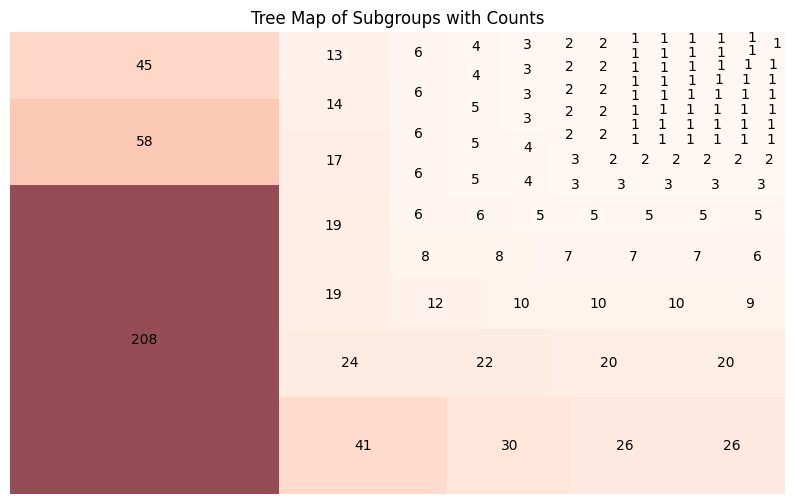

In [47]:
# Import necessary libraries
import matplotlib.pyplot as plt
import squarify


import matplotlib.cm as cm

# Create a color scale based on count values
norm = plt.Normalize(count_by_category['count'].min(), count_by_category['count'].max())
colors = cm.Reds(norm(count_by_category['count']))

# Plot the tree map with color gradients
plt.figure(figsize=(10, 6))
squarify.plot(sizes=count_by_category['count'], label=count_by_category['count'], color=colors, alpha=0.7)
plt.axis('off')
plt.title('Tree Map of Subgroups with Counts')
#plt.show()
plt.savefig('tree_map_high_quality.png', dpi=300)


##### Sunburst for MP subgroups

In [48]:

import plotly.express as px

# Create a sunburst chart
fig = px.sunburst(group_subgroup_counts_df, path=['group', 'subgroup', 'count'], values='count', color='count', color_continuous_scale='blues', width=800, height=500)
fig.update_layout(title_text='Sunburst Chart of Membrane Protein Sub-group.')
fig.write_image("sunburst_chart_high_dimensional.png", width=1800, height=1200, scale=2)
fig.show()



##### Interactive Tree Map for Subgroup

In [49]:
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
fig = px.treemap(group_subgroup_counts_df, path=["group", 'subgroup', 'count'], values='count',
    color='group', hover_data=["group", 'subgroup', 'count'],
    color_discrete_map={'MONOTOPIC MEMBRANE PROTEINS':'#2ca25f', 'TRANSMEMBRANE PROTEINS:ALPHA-HELICAL':'#fdc086', 'TRANSMEMBRANE PROTEINS:BETA-BARREL':'#beaed4'},
    color_continuous_midpoint=np.average(group_subgroup_counts_df['count'], weights=group_subgroup_counts_df['count']),
    
    )
fig.update_traces(root_color="lightgrey", )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.write_image("hierarchical_tree_map.png", scale=3)  #
fig.show()

##### Cumulative sum of resolved Membrane Protein (MP) Structures over time**

In [79]:
from src.services.pages import Pages
import pandas as pd
import altair as alt

pages = Pages(mp_and_pdb)
data_map, map= pages.getMap()
map_chart = alt.Chart.from_dict(map)
map_chart

alt.LayerChart(...)

In [80]:

# Create a DataFrame from the provided data
map_df = pd.DataFrame(data_map)

# Create the chart using Altair
chart_bar = alt.Chart(map_df).transform_filter(
    alt.datum.count > 0
).mark_bar().encode(
    x='country:O',
    y='count:Q',
    color=alt.Color("count:Q", 
        scale=alt.Scale(domain=[0, 2000]), 
        legend=alt.Legend(
            title="No. of released Membrane Protein Structure", 
            orient="bottom", titleLimit=2000
        )
    ),
    tooltip=alt.Tooltip('count:Q', title="No. of released Membrane Protein Structure")
).properties(
    title='Resolved Membrane Protein (MP) Structures across different countries.',
    width="container"
)

chart_bar


alt.Chart(...)

##### US Contribution Against Other Countries

In [81]:
import pandas as pd
import altair as alt

data = map_df[(map_df['count'] > 0) & map_df['country'].notna() & (map_df['country'] != 'None')]
us_uk_data = data[data['iso_code_2'].isin(['US', 'GB'])]
others_data = data[~data['iso_code_2'].isin(['US', 'GB'])]

# Summing US and UK, and preparing individual entries for other countries
grouped_us_uk = us_uk_data.groupby('iso_code_2').sum().reset_index()
grouped_others = others_data.groupby('iso_code_2').sum().reset_index()

# Setting a common group for stacking in visualization
grouped_us_uk['Group'] = 'US and UK'
grouped_others['Group'] = 'Others'

# Concatenating the results
vis_data = pd.concat([grouped_us_uk, grouped_others], ignore_index=True)

# Visualization
chart = alt.Chart(vis_data).mark_bar().encode(
    y='sum(count):Q',
    x=alt.Y('Group:N', title='Group'),
    #color=alt.Color('iso_code_2:N',legend=alt.Legend(title="Country")),
    tooltip=[alt.Tooltip('iso_code_2:N', title='Country'), alt.Tooltip('sum(count):Q', title='Total Count')]
).properties(
    width=400,
    height=300,
    title='Stacked Contributions by Country'
)

chart.display()


alt.Chart(...)

##### Make a Fancy Bar Chart

In [82]:

# Create the lollipop chart
lollipop_chart = alt.Chart(map_df).transform_filter(
    alt.datum.count > 0
).mark_circle(size=100).encode(
    x=alt.X('country', axis=alt.Axis(labelAngle=45)),  # Rotate x-axis labels for better readability
    y='count',
    color=alt.Color("count:Q", 
        scale=alt.Scale(domain=[0, 2000]), 
        legend=alt.Legend(
            title="No. of released Membrane Protein Structure", 
            orient="bottom", titleLimit=2000
        )
    ),
    tooltip=alt.Tooltip('count:Q', title="No. of released Membrane Protein Structure")
).properties(
    width="container",
    title='Lollipop Chart'
)

# Add the vertical lines (lollipops)
lollipop_lines = alt.Chart(map_df).transform_filter(
    alt.datum.count > 0
).mark_rule(color='black').encode(
    x='country',
    y='count',
    color=alt.Color("count:Q", 
        scale=alt.Scale(domain=[0, 2000]), 
        legend=alt.Legend(
            title="No. of released Membrane Protein Structure", 
            orient="bottom", titleLimit=2000
        )
    ),
    tooltip=alt.Tooltip('count:Q', title="No. of released Membrane Protein Structure")
)

# Combine the chart and lines
chart = (lollipop_chart + lollipop_lines)
chart

alt.LayerChart(...)

##### Summary statistics

In [88]:
import os
# Path to save all images for summary statistics
directory = './summary-statistics'
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully.")
else:
    print(f"Directory '{directory}' already exists.")


request_for_group = '''
    group,
    group*monotopic_membrane_proteins,
    group*transmembrane_proteins:alpha-helical,
    group*transmembrane_proteins:beta-barrel,
    rcsentinfo_selected_polymer_entity_types,
    expressed_in_species*e._coli,
    expressed_in_species*hek293_cells,
    expressed_in_species*s._frugiperda,species,
    expressed_in_species,processed_resolution,
    rcsentinfo_software_programs_combined,
    symspagroup_name_hm,rcsentinfo_molecular_weight,
    rcsentinfo_experimental_method,
    rcsentinfo_experimental_method*x-ray,
    rcsentinfo_experimental_method*nmr,
    rcsentinfo_experimental_method*em,
    rcsentinfo_experimental_method*multiple_methods,
    rcsentinfo_selected_polymer_entity_types*protein_(only)
'''.replace("\n", "").replace(" ", "")
default_display = [
    'taxonomic_domain',
    'taxonomic_domain*bacteria', 
    'taxonomic_domain*eukaryota', 
    'taxonomic_domain*viruses', 
    'taxonomic_domain*unclassified', 
    'citation_country'
]
# Split the string on commas to create a list
request_for_group_list = request_for_group.split(',')
# merge array/list
group_list = default_display + request_for_group_list

#chart config
conf = {}

# Convert the list to a set to get unique elements
unique_group_list = list(set(group_list))
for (key, graph) in enumerate(unique_group_list):
    group_graph, _ = pages.view_dashboard(graph, conf)
    group_graph_chart = alt.Chart.from_dict(group_graph).properties(
        width=1000,  # Set desired width
        height=800  # Set desired height
    )
    group_graph_chart.save('./summary-statistics/' + graph + 'chart.png', scale_factor=2.0)
print("images has been saved to '/summary-statistics'")

Directory './summary-statistics' already exists.


/Users/AwotoroE-Dev/Desktop/mpvis/.venv_mpvis/lib/python3.9/site-packages/altair/utils/core.py:230: UserWarning:

I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.



images has been saved to '/summary-statistics'
